# LSTM (tensorflow)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

C:\Users\blue8\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameter

In [2]:
n_in = 1
n_out = 1

length_of_sequence = 2 * 100
maxlen = 25
n_hidden = 30

epochs = 400
batch_size = 15
learning_rate = 0.01

### Data

##### (1) Generating Data

In [3]:
def sin(x, T = 100) :
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T = 100, ampl = 0.05) :
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low = -1, high = 1, size = len(x))
    return sin(x) + noise

In [4]:
x = np.arange(0, 200 + 1)
f = toy_problem(T = 100, ampl = 0.05)

data = []
target = []

for i in range(0, length_of_sequence - maxlen + 1) :
    data.append(f[i:(i + maxlen)])
    target.append(f[i + maxlen])
    
X = np.array(data)
X = X.reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(target), 1)

print(X.shape, Y.shape)

(176, 25, 1) (176, 1)


##### (2) Train / Test

In [5]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = N_validation)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

#전체 데이터의 90%는 train data, 10%는 test data로 사용.

(158, 25, 1) (18, 25, 1) (158, 1) (18, 1)


### Model

##### (1) Layer

In [6]:
def inference(x, n_batch, maxlen = None, n_hidden = None, n_out = None) :
    
    # State 2개 : a state & c state
    a_init_state = tf.zeros(shape = (n_batch, n_hidden))
    a_state = a_init_state
    c_init_state = tf.zeros(shape = (n_batch, n_hidden))
    c_state = c_init_state
    
    # Variable 설정
    Wac = tf.get_variable("Wac", shape = (n_hidden, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Wau = tf.get_variable("Wau", shape = (n_hidden, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Waf = tf.get_variable("Waf", shape = (n_hidden, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Wao = tf.get_variable("Wao", shape = (n_hidden, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Wxc = tf.get_variable("Wxc", shape = (1, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Wxu = tf.get_variable("Wxu", shape = (1, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Wxf = tf.get_variable("Wxf", shape = (1, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Wxo = tf.get_variable("Wxo", shape = (1, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    bc  = tf.get_variable("bc", shape = (1, n_hidden),
                          initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    bu  = tf.get_variable("bu", shape = (1, n_hidden),
                          initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    bf  = tf.get_variable("bf", shape = (1, n_hidden),
                          initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    bo  = tf.get_variable("bo", shape = (1, n_hidden),
                          initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    
    # Output
    c_outputs = []
    a_outputs = []
    
    for t in range(maxlen) :
        
        c_tilda = tf.tanh(tf.matmul(a_state, Wac) + tf.matmul(x[:, t, :], Wxc) + bc)
        #x[:, t, :].shape = (n_batch, 1)
        #a_state(n_batch, 30) * Wac(30, 30) + x[:, t, :](n_batch, 1) * Wxc(1, 30) + bc(broadcasting to (n_batch, 30))
        #c_tilda.shape = (n_batch, 30)
        
        Gu = tf.sigmoid(tf.matmul(a_state, Wau) + tf.matmul(x[:, t, :], Wxu) + bu) #Gu.shape = (n_batch, 30)
        Gf = tf.sigmoid(tf.matmul(a_state, Waf) + tf.matmul(x[:, t, :], Wxf) + bf) #Gf.shape = (n_batch, 30)
        Go = tf.sigmoid(tf.matmul(a_state, Wao) + tf.matmul(x[:, t, :], Wxo) + bo) #Go.shape = (n_batch, 30)
        
        c_state = tf.multiply(Gu, c_tilda) + tf.multiply(Gf, c_state) #c_state.shape = (n_batch, 30)
        a_state = tf.multiply(Go, tf.tanh(c_state)) #a_state.shape = (n_batch, 30)
        #tf.multiply : element wise product
        
        c_outputs.append(c_state)
        a_outputs.append(a_state)
    
    #for문 : shape이 (n_batch, 1)인 데이터를 가지고 c_state, a_state를 매 cell마다 업데이트하는 과정.
    #for문을 끝낸 c_outputs와 a_outputs는 최종적으로 shape이 (n_batch, 30)인 c_state와 a_state가 25개가 있는 list 형태
    #이 중 yhat을 만드는 데 필요한 a_outputs list의 마지막 원소를 a_output으로 입력 받는다.
    
    c_output = c_outputs[-1] #c_outputs[-1] 이 과정은 사실 필요 없는 과정이다.
    a_output = a_outputs[-1] #a_output.shape = (n_batch, 30)
    
    #최종 output : y (yhat, predict y)
    #y = W * a<t> + b
    W = tf.Variable(tf.truncated_normal([n_hidden, n_out], stddev = 0.01))
    b = tf.Variable(tf.zeros([n_out])) #b.shape = (n_out,) 이지만 y 계산할 때 (n_batch, n_out)으로 broadcasting 된다.
    y = tf.matmul(a_output, W) + b #y.shape = (n_batch, n_out) = (n_batch, 1)
    
    return y

##### (2) Placeholder

In [7]:
x = tf.placeholder(tf.float32, shape = [None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape = [None, n_out])
n_batch = tf.placeholder(tf.int32, shape = [])
y = inference(x = x, n_batch = n_batch, maxlen = maxlen, n_hidden = n_hidden, n_out = n_out)

### Loss function & Train Step

In [8]:
loss = tf.reduce_mean(tf.square(y - t)) #Loss : Mean Square Error
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = 0.9, beta2 = 0.999)
train_step = optimizer.minimize(loss)

### Initializing

In [9]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Training

In [10]:
epochs = epochs
batch_size = batch_size
n_batches = N_train // batch_size

my_loss = []

for epoch in range(epochs) :
    X_, Y_ = shuffle(train_x, train_y)
    #매 epoch 마다 train_x와 train_y의 순서를 섞어서 X_와 Y_라는 새로운 데이터를 준비한다.
    
    for i in range(n_batches) :
        start = i * batch_size
        end = start + batch_size
        sess.run(train_step, feed_dict = {x : X_[start:end], t : Y_[start:end], n_batch : batch_size})
        #매 epoch 마다 batch_size 크기의 X_와 Y_를 이용해 n_batches번 training 시킨다.
        #즉, train_x와 train_y를 순서를 섞은 뒤 15개씩 뽑아서 10번 training 시키는데 이 전체 과정을 총 400번 반복한다.
        
    val_loss = loss.eval(session = sess, feed_dict = {x : test_x, t : test_y, n_batch : N_validation})
    my_loss.append(val_loss)
        
    print("epoch:", epoch, "validation loss:", val_loss) 
    #매 epoch 마다 test data에서의 loss 기록.

epoch: 0 validation loss: 0.07874417
epoch: 1 validation loss: 0.008432119
epoch: 2 validation loss: 0.0025630977
epoch: 3 validation loss: 0.0019300439
epoch: 4 validation loss: 0.0017324961
epoch: 5 validation loss: 0.0019967132
epoch: 6 validation loss: 0.0015185983
epoch: 7 validation loss: 0.00240311
epoch: 8 validation loss: 0.001602367
epoch: 9 validation loss: 0.0030964462
epoch: 10 validation loss: 0.0047441074
epoch: 11 validation loss: 0.0023088607
epoch: 12 validation loss: 0.0015552987
epoch: 13 validation loss: 0.0023906701
epoch: 14 validation loss: 0.0014007731
epoch: 15 validation loss: 0.0023382877
epoch: 16 validation loss: 0.0021679287
epoch: 17 validation loss: 0.0014122888
epoch: 18 validation loss: 0.0014464594
epoch: 19 validation loss: 0.0013798614
epoch: 20 validation loss: 0.0015823222
epoch: 21 validation loss: 0.0018035389
epoch: 22 validation loss: 0.0021157737
epoch: 23 validation loss: 0.0013966254
epoch: 24 validation loss: 0.0015414293
epoch: 25 valida

epoch: 207 validation loss: 0.0011792103
epoch: 208 validation loss: 0.0012440044
epoch: 209 validation loss: 0.0010078712
epoch: 210 validation loss: 0.0014961761
epoch: 211 validation loss: 0.0017877168
epoch: 212 validation loss: 0.0019123039
epoch: 213 validation loss: 0.0022378876
epoch: 214 validation loss: 0.0012957898
epoch: 215 validation loss: 0.0012455465
epoch: 216 validation loss: 0.0010368908
epoch: 217 validation loss: 0.001100895
epoch: 218 validation loss: 0.001190738
epoch: 219 validation loss: 0.0012349449
epoch: 220 validation loss: 0.0011070322
epoch: 221 validation loss: 0.0020574338
epoch: 222 validation loss: 0.0011246843
epoch: 223 validation loss: 0.0011334537
epoch: 224 validation loss: 0.0012772591
epoch: 225 validation loss: 0.0012899615
epoch: 226 validation loss: 0.0011677479
epoch: 227 validation loss: 0.0011955304
epoch: 228 validation loss: 0.0010404213
epoch: 229 validation loss: 0.0018272265
epoch: 230 validation loss: 0.0012287428
epoch: 231 validat

### Plot

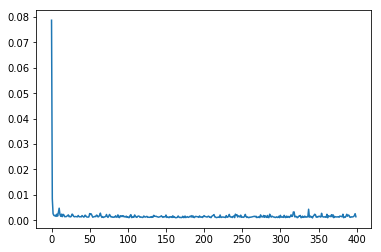

In [11]:
plt.plot(my_loss)

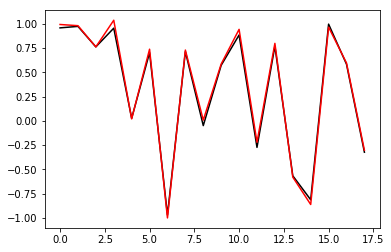

In [12]:
predict_y = y.eval(session = sess, feed_dict = {x : test_x, n_batch : N_validation})
true_y = test_y

plt.plot(true_y, "k") #test data의 true y
plt.plot(predict_y, "r") #test data의 predict y